## RandAugmentation_simple
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [1]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [2]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion

In [3]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

DATASET_DIR = "./input/cifar10"

In [4]:
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)
    

In [5]:
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset
    

In [6]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(_val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

In [7]:
import optuna
import yaml

In [8]:
EPOCHS = 10
BATCH_SIZE = 256
    
def objective(trial: optuna.Trial) -> float:
    img_size = 32

    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())
    
        
    train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, 
                                                            aug_fcns = tuple(augmentation_functions), 
                                                            validation_ratio=0.8)
    
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)
    
    with open("./configs/model/mobilenetv3.yaml", "r") as f:
        model_cfg = yaml.load(f, yaml.SafeLoader)

    model_cfg['backbone'][-1][-1] = [10]

    model = Model(model_cfg, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)

    train_loader = DataLoader(dataset=train_dataset, 
                              pin_memory=torch.cuda.is_available(), 
                              shuffle=True, 
                              batch_size=BATCH_SIZE, 
                              num_workers=4, 
                              drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, 
                            pin_memory=torch.cuda.is_available(), 
                            shuffle=False, 
                            batch_size=BATCH_SIZE, 
                            num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, 
                             pin_memory=torch.cuda.is_available(), 
                             shuffle=False, 
                             batch_size=BATCH_SIZE, 
                             num_workers=4)

    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1

[I 2021-11-23 09:28:37,862] A new study created in memory with name: autoaug


0it [00:00, ?it/s]

Extracting ./input/cifar10/cifar-10-python.tar.gz to ./input/cifar10
Files already downloaded and verified


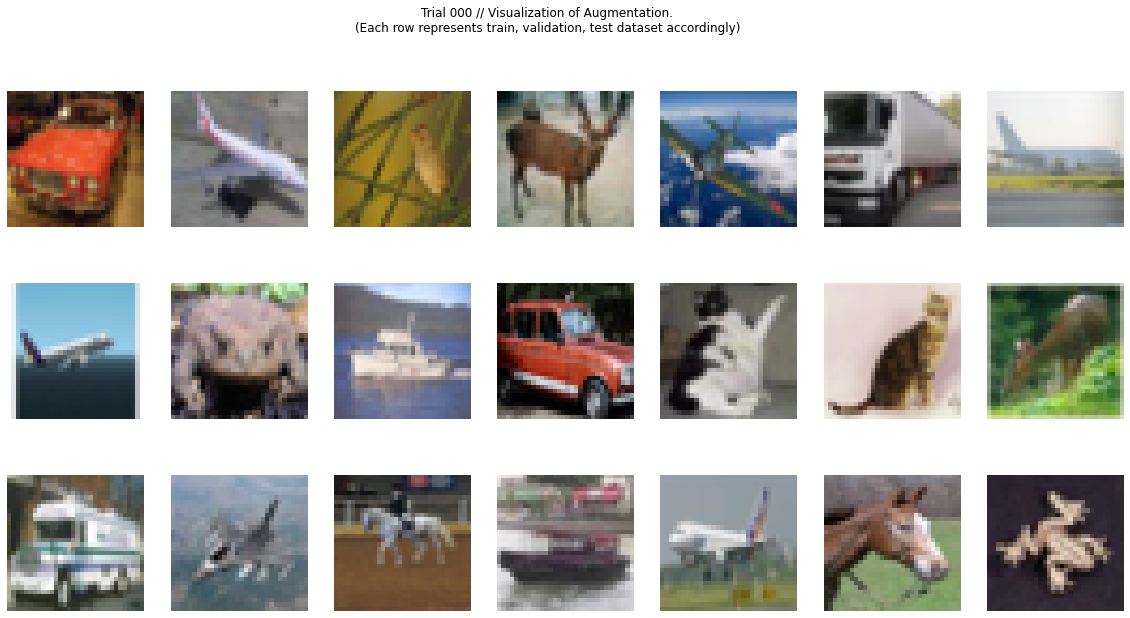

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.942, Acc: 28.47% F1(macro): 0.28: 100%|██████████| 156/156 [00:09<00:00, 15.66it/s]
 Val:       Loss: 1.588, Acc: 41.79% F1(macro): 0.40: 100%|██████████| 40/40 [00:00<00:00, 40.03it/s]


Model saved. Current best test f1: 0.400


Train: [002] Loss: 1.473, Acc: 46.44% F1(macro): 0.46: 100%|██████████| 156/156 [00:09<00:00, 15.75it/s]
 Val:       Loss: 1.397, Acc: 48.63% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 39.99it/s]


Model saved. Current best test f1: 0.487


Train: [003] Loss: 1.316, Acc: 52.34% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 15.49it/s]
 Val:       Loss: 1.279, Acc: 53.37% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 39.24it/s]


Model saved. Current best test f1: 0.531


Train: [004] Loss: 1.210, Acc: 56.35% F1(macro): 0.56: 100%|██████████| 156/156 [00:09<00:00, 15.95it/s]
 Val:       Loss: 1.214, Acc: 56.97% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 38.00it/s]


Model saved. Current best test f1: 0.568


Train: [005] Loss: 1.123, Acc: 59.62% F1(macro): 0.59: 100%|██████████| 156/156 [00:09<00:00, 15.71it/s]
 Val:       Loss: 1.150, Acc: 58.86% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.62it/s]


Model saved. Current best test f1: 0.583


Train: [006] Loss: 1.058, Acc: 62.22% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 15.60it/s]
 Val:       Loss: 1.112, Acc: 60.12% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 37.38it/s]


Model saved. Current best test f1: 0.596


Train: [007] Loss: 0.986, Acc: 64.89% F1(macro): 0.65: 100%|██████████| 156/156 [00:10<00:00, 15.46it/s]
 Val:       Loss: 1.054, Acc: 62.18% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 39.23it/s]


Model saved. Current best test f1: 0.616


Train: [008] Loss: 0.939, Acc: 66.21% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 14.77it/s]
 Val:       Loss: 1.031, Acc: 63.92% F1(macro): 0.64: 100%|██████████| 40/40 [00:01<00:00, 37.65it/s]


Model saved. Current best test f1: 0.638


Train: [009] Loss: 0.892, Acc: 67.98% F1(macro): 0.68: 100%|██████████| 156/156 [00:10<00:00, 15.32it/s]
 Val:       Loss: 1.020, Acc: 64.09% F1(macro): 0.64: 100%|██████████| 40/40 [00:01<00:00, 39.77it/s]


Model saved. Current best test f1: 0.639


Train: [010] Loss: 0.851, Acc: 69.64% F1(macro): 0.70: 100%|██████████| 156/156 [00:10<00:00, 15.57it/s]
 Val:       Loss: 1.016, Acc: 64.84% F1(macro): 0.65: 100%|██████████| 40/40 [00:00<00:00, 40.91it/s]


Model saved. Current best test f1: 0.650
TEST DATASET


 Val:       Loss: 1.005, Acc: 64.74% F1(macro): 0.65: 100%|██████████| 40/40 [00:00<00:00, 40.43it/s]
[I 2021-11-23 09:30:58,881] Trial 0 finished with value: 0.6480624514967079 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


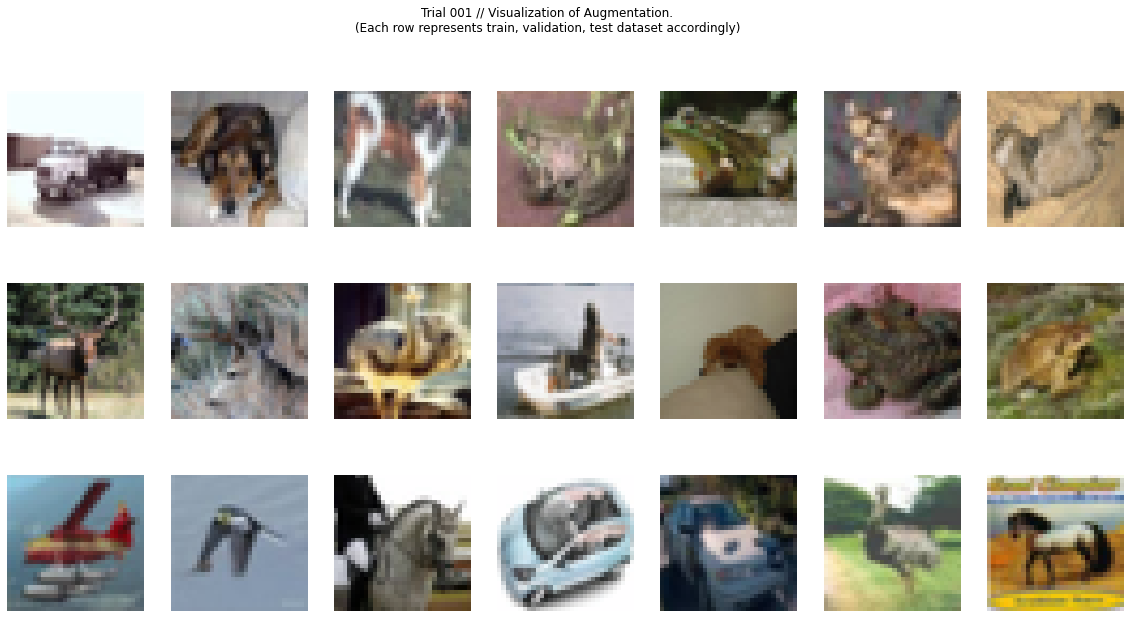

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.923, Acc: 28.53% F1(macro): 0.28: 100%|██████████| 156/156 [00:09<00:00, 15.80it/s]
 Val:       Loss: 1.695, Acc: 38.09% F1(macro): 0.36: 100%|██████████| 40/40 [00:00<00:00, 40.90it/s]


Model saved. Current best test f1: 0.362


Train: [002] Loss: 1.499, Acc: 44.82% F1(macro): 0.44: 100%|██████████| 156/156 [00:09<00:00, 16.15it/s]
 Val:       Loss: 1.413, Acc: 48.42% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 39.93it/s]


Model saved. Current best test f1: 0.478


Train: [003] Loss: 1.326, Acc: 51.78% F1(macro): 0.52: 100%|██████████| 156/156 [00:09<00:00, 15.68it/s]
 Val:       Loss: 1.357, Acc: 51.02% F1(macro): 0.50: 100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Model saved. Current best test f1: 0.501


Train: [004] Loss: 1.206, Acc: 56.42% F1(macro): 0.56: 100%|██████████| 156/156 [00:09<00:00, 16.04it/s]
 Val:       Loss: 1.278, Acc: 53.66% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 38.33it/s]


Model saved. Current best test f1: 0.533


Train: [005] Loss: 1.117, Acc: 59.93% F1(macro): 0.60: 100%|██████████| 156/156 [00:09<00:00, 15.70it/s]
 Val:       Loss: 1.250, Acc: 55.84% F1(macro): 0.56: 100%|██████████| 40/40 [00:00<00:00, 40.65it/s]


Model saved. Current best test f1: 0.559


Train: [006] Loss: 1.032, Acc: 62.88% F1(macro): 0.63: 100%|██████████| 156/156 [00:09<00:00, 15.69it/s]
 Val:       Loss: 1.243, Acc: 56.84% F1(macro): 0.56: 100%|██████████| 40/40 [00:00<00:00, 40.52it/s]


Model saved. Current best test f1: 0.565


Train: [007] Loss: 0.960, Acc: 65.77% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 15.29it/s]
 Val:       Loss: 1.221, Acc: 57.95% F1(macro): 0.58: 100%|██████████| 40/40 [00:00<00:00, 40.60it/s]


Model saved. Current best test f1: 0.577


Train: [008] Loss: 0.913, Acc: 67.49% F1(macro): 0.67: 100%|██████████| 156/156 [00:10<00:00, 15.07it/s]
 Val:       Loss: 1.207, Acc: 58.68% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 37.63it/s]


Model saved. Current best test f1: 0.584


Train: [009] Loss: 0.842, Acc: 70.09% F1(macro): 0.70: 100%|██████████| 156/156 [00:10<00:00, 15.41it/s]
 Val:       Loss: 1.226, Acc: 58.32% F1(macro): 0.58: 100%|██████████| 40/40 [00:00<00:00, 42.56it/s]
Train: [010] Loss: 0.809, Acc: 71.20% F1(macro): 0.71: 100%|██████████| 156/156 [00:10<00:00, 14.70it/s]
 Val:       Loss: 1.182, Acc: 60.03% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.91it/s]


Model saved. Current best test f1: 0.595
TEST DATASET


 Val:       Loss: 1.179, Acc: 60.46% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.73it/s]
[I 2021-11-23 09:33:01,943] Trial 1 finished with value: 0.6004912299505036 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


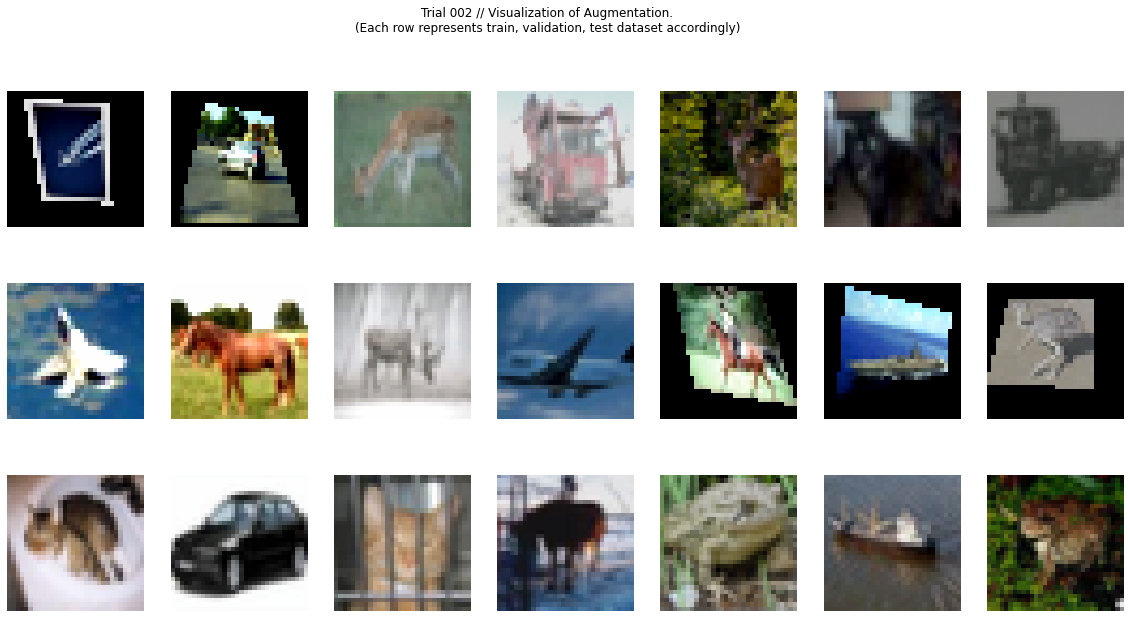

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.149, Acc: 19.28% F1(macro): 0.19: 100%|██████████| 156/156 [00:10<00:00, 15.20it/s]
 Val:       Loss: 2.097, Acc: 27.10% F1(macro): 0.24: 100%|██████████| 40/40 [00:02<00:00, 17.80it/s]


Model saved. Current best test f1: 0.240


Train: [002] Loss: 1.836, Acc: 31.92% F1(macro): 0.31: 100%|██████████| 156/156 [00:10<00:00, 15.06it/s]
 Val:       Loss: 1.770, Acc: 34.98% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 17.13it/s]


Model saved. Current best test f1: 0.332


Train: [003] Loss: 1.713, Acc: 37.11% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.73it/s]
 Val:       Loss: 1.692, Acc: 37.92% F1(macro): 0.37: 100%|██████████| 40/40 [00:02<00:00, 17.96it/s]


Model saved. Current best test f1: 0.371


Train: [004] Loss: 1.628, Acc: 40.41% F1(macro): 0.40: 100%|██████████| 156/156 [00:10<00:00, 15.17it/s]
 Val:       Loss: 1.606, Acc: 40.41% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 17.60it/s]


Model saved. Current best test f1: 0.389


Train: [005] Loss: 1.578, Acc: 42.50% F1(macro): 0.42: 100%|██████████| 156/156 [00:10<00:00, 14.79it/s]
 Val:       Loss: 1.548, Acc: 43.79% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 18.04it/s]


Model saved. Current best test f1: 0.427


Train: [006] Loss: 1.538, Acc: 44.18% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.47it/s]
 Val:       Loss: 1.581, Acc: 42.97% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 17.18it/s]
Train: [007] Loss: 1.492, Acc: 45.95% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 15.16it/s]
 Val:       Loss: 1.465, Acc: 46.57% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 16.32it/s]


Model saved. Current best test f1: 0.460


Train: [008] Loss: 1.440, Acc: 47.52% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 15.00it/s]
 Val:       Loss: 1.451, Acc: 47.51% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 17.87it/s]


Model saved. Current best test f1: 0.471


Train: [009] Loss: 1.404, Acc: 49.44% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 15.10it/s]
 Val:       Loss: 1.400, Acc: 49.17% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s]


Model saved. Current best test f1: 0.484


Train: [010] Loss: 1.370, Acc: 50.59% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 15.14it/s]
 Val:       Loss: 1.400, Acc: 49.28% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 18.04it/s]


Model saved. Current best test f1: 0.489
TEST DATASET


 Val:       Loss: 1.272, Acc: 53.64% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 39.94it/s]
[I 2021-11-23 09:35:21,318] Trial 2 finished with value: 0.5319180643078407 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


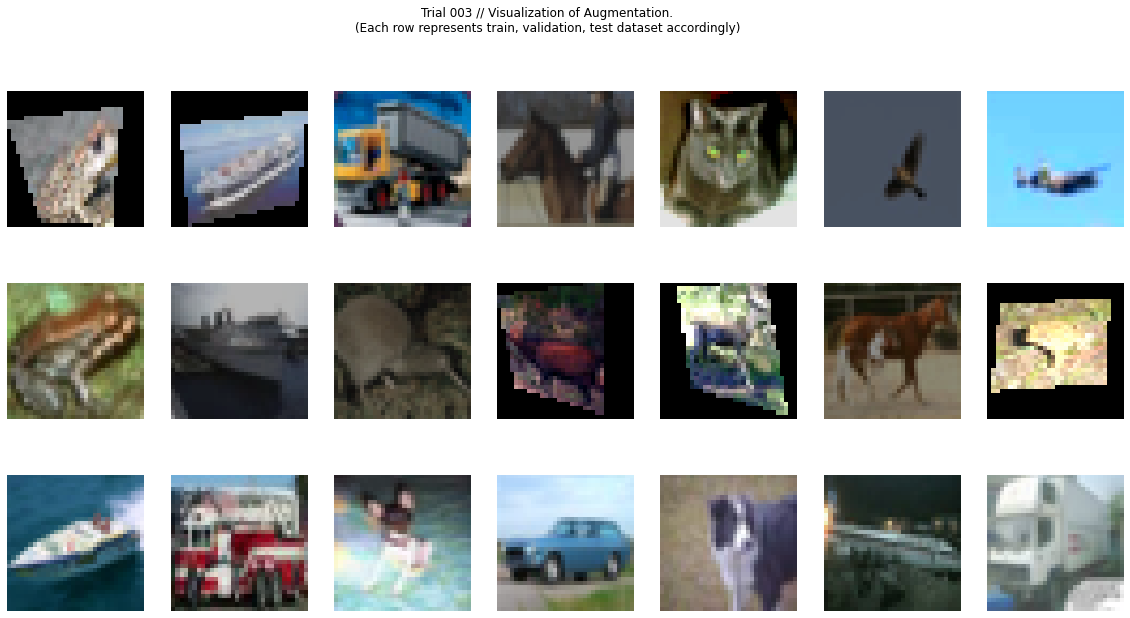

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.181, Acc: 18.22% F1(macro): 0.18: 100%|██████████| 156/156 [00:10<00:00, 15.14it/s]
 Val:       Loss: 2.033, Acc: 25.52% F1(macro): 0.22: 100%|██████████| 40/40 [00:02<00:00, 18.30it/s]


Model saved. Current best test f1: 0.224


Train: [002] Loss: 1.859, Acc: 31.18% F1(macro): 0.31: 100%|██████████| 156/156 [00:10<00:00, 15.06it/s]
 Val:       Loss: 1.811, Acc: 34.86% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 18.27it/s]


Model saved. Current best test f1: 0.332


Train: [003] Loss: 1.716, Acc: 37.15% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 15.29it/s]
 Val:       Loss: 1.668, Acc: 38.86% F1(macro): 0.38: 100%|██████████| 40/40 [00:02<00:00, 16.90it/s]


Model saved. Current best test f1: 0.378


Train: [004] Loss: 1.627, Acc: 40.49% F1(macro): 0.40: 100%|██████████| 156/156 [00:10<00:00, 14.94it/s]
 Val:       Loss: 1.615, Acc: 41.20% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 15.95it/s]


Model saved. Current best test f1: 0.408


Train: [005] Loss: 1.574, Acc: 42.82% F1(macro): 0.42: 100%|██████████| 156/156 [00:10<00:00, 14.45it/s]
 Val:       Loss: 1.634, Acc: 42.44% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s]
Train: [006] Loss: 1.523, Acc: 44.42% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 15.13it/s]
 Val:       Loss: 1.516, Acc: 45.74% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 18.32it/s]


Model saved. Current best test f1: 0.456


Train: [007] Loss: 1.468, Acc: 46.57% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 15.23it/s]
 Val:       Loss: 1.461, Acc: 47.18% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 17.99it/s]


Model saved. Current best test f1: 0.467


Train: [008] Loss: 1.436, Acc: 47.94% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 15.27it/s]
 Val:       Loss: 1.451, Acc: 47.94% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 17.91it/s]


Model saved. Current best test f1: 0.476


Train: [009] Loss: 1.398, Acc: 49.45% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 14.98it/s]
 Val:       Loss: 1.416, Acc: 49.81% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 18.16it/s]


Model saved. Current best test f1: 0.497


Train: [010] Loss: 1.379, Acc: 50.14% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.82it/s]
 Val:       Loss: 1.437, Acc: 47.43% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s]

TEST DATASET



 Val:       Loss: 1.285, Acc: 54.39% F1(macro): 0.54: 100%|██████████| 40/40 [00:00<00:00, 40.53it/s]
[I 2021-11-23 09:37:39,844] Trial 3 finished with value: 0.5373255179043915 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


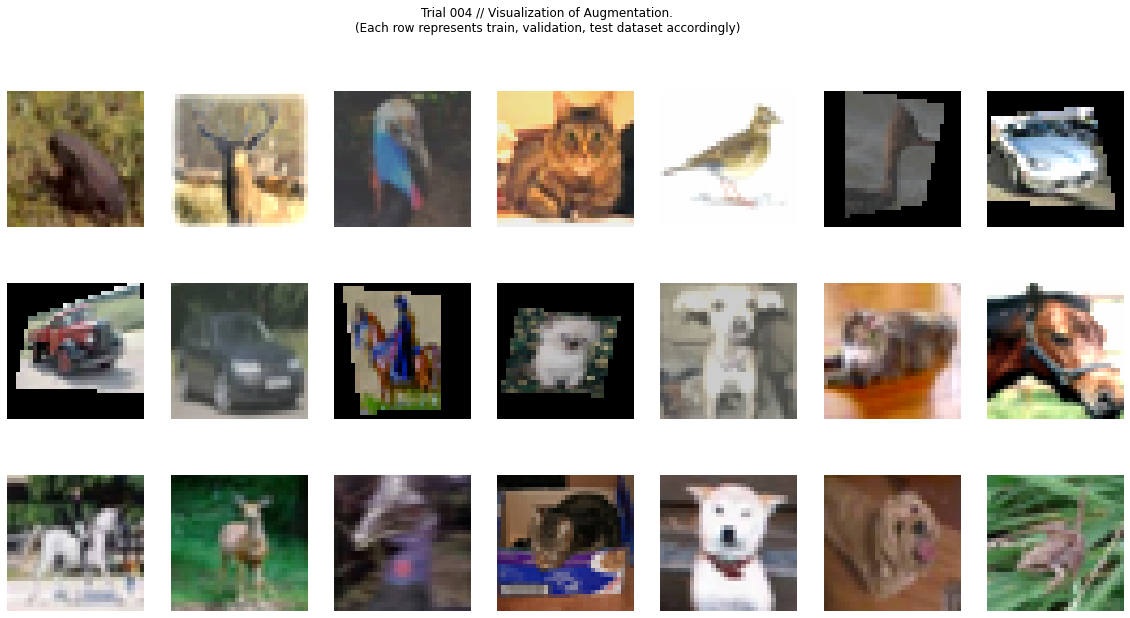

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.219, Acc: 17.71% F1(macro): 0.17: 100%|██████████| 156/156 [00:10<00:00, 14.39it/s]
 Val:       Loss: 2.055, Acc: 24.16% F1(macro): 0.23: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s]


Model saved. Current best test f1: 0.226


Train: [002] Loss: 1.903, Acc: 30.55% F1(macro): 0.30: 100%|██████████| 156/156 [00:10<00:00, 15.03it/s]
 Val:       Loss: 1.782, Acc: 34.68% F1(macro): 0.34: 100%|██████████| 40/40 [00:02<00:00, 18.27it/s]


Model saved. Current best test f1: 0.339


Train: [003] Loss: 1.745, Acc: 36.42% F1(macro): 0.36: 100%|██████████| 156/156 [00:10<00:00, 14.83it/s]
 Val:       Loss: 1.719, Acc: 38.14% F1(macro): 0.37: 100%|██████████| 40/40 [00:02<00:00, 18.24it/s]


Model saved. Current best test f1: 0.374


Train: [004] Loss: 1.668, Acc: 39.24% F1(macro): 0.39: 100%|██████████| 156/156 [00:10<00:00, 15.05it/s]
 Val:       Loss: 1.621, Acc: 40.37% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 15.68it/s]


Model saved. Current best test f1: 0.395


Train: [005] Loss: 1.617, Acc: 41.13% F1(macro): 0.41: 100%|██████████| 156/156 [00:10<00:00, 15.01it/s]
 Val:       Loss: 1.567, Acc: 42.69% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 17.45it/s]


Model saved. Current best test f1: 0.418


Train: [006] Loss: 1.566, Acc: 43.33% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.82it/s]
 Val:       Loss: 1.545, Acc: 43.56% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 18.14it/s]


Model saved. Current best test f1: 0.430


Train: [007] Loss: 1.526, Acc: 44.68% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.84it/s]
 Val:       Loss: 1.513, Acc: 45.17% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 18.00it/s]


Model saved. Current best test f1: 0.448


Train: [008] Loss: 1.482, Acc: 46.27% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.67it/s]
 Val:       Loss: 1.486, Acc: 46.57% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s]


Model saved. Current best test f1: 0.462


Train: [009] Loss: 1.457, Acc: 47.40% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.84it/s]
 Val:       Loss: 1.456, Acc: 47.10% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 18.10it/s]


Model saved. Current best test f1: 0.462


Train: [010] Loss: 1.427, Acc: 48.43% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.73it/s]
 Val:       Loss: 1.434, Acc: 47.82% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 18.38it/s]


Model saved. Current best test f1: 0.475
TEST DATASET


 Val:       Loss: 1.289, Acc: 53.89% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 39.27it/s]
[I 2021-11-23 09:40:01,123] Trial 4 finished with value: 0.5291859481567935 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


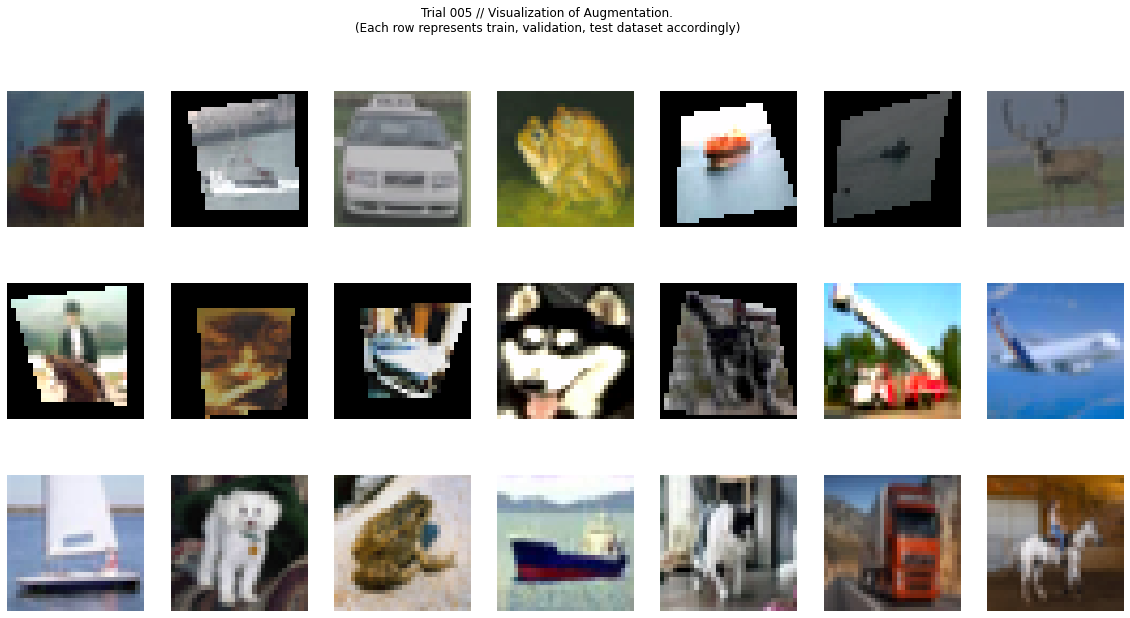

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.168, Acc: 18.70% F1(macro): 0.18: 100%|██████████| 156/156 [00:10<00:00, 15.10it/s]
 Val:       Loss: 1.952, Acc: 27.21% F1(macro): 0.26: 100%|██████████| 40/40 [00:02<00:00, 17.85it/s]


Model saved. Current best test f1: 0.255


Train: [002] Loss: 1.845, Acc: 31.97% F1(macro): 0.31: 100%|██████████| 156/156 [00:10<00:00, 15.31it/s]
 Val:       Loss: 1.758, Acc: 34.88% F1(macro): 0.33: 100%|██████████| 40/40 [00:02<00:00, 18.03it/s]


Model saved. Current best test f1: 0.335


Train: [003] Loss: 1.695, Acc: 37.78% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.82it/s]
 Val:       Loss: 1.661, Acc: 39.40% F1(macro): 0.38: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s]


Model saved. Current best test f1: 0.383


Train: [004] Loss: 1.610, Acc: 41.09% F1(macro): 0.41: 100%|██████████| 156/156 [00:10<00:00, 15.20it/s]
 Val:       Loss: 1.590, Acc: 42.36% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s]


Model saved. Current best test f1: 0.406


Train: [005] Loss: 1.547, Acc: 43.63% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.49it/s]
 Val:       Loss: 1.531, Acc: 44.02% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 18.16it/s]


Model saved. Current best test f1: 0.432


Train: [006] Loss: 1.485, Acc: 46.10% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 15.41it/s]
 Val:       Loss: 1.560, Acc: 46.48% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 18.23it/s]


Model saved. Current best test f1: 0.452


Train: [007] Loss: 1.443, Acc: 47.62% F1(macro): 0.47: 100%|██████████| 156/156 [00:11<00:00, 14.11it/s]
 Val:       Loss: 1.431, Acc: 48.96% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 17.97it/s]


Model saved. Current best test f1: 0.481


Train: [008] Loss: 1.398, Acc: 49.61% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 15.10it/s]
 Val:       Loss: 1.403, Acc: 49.96% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 17.70it/s]


Model saved. Current best test f1: 0.497


Train: [009] Loss: 1.351, Acc: 51.59% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.75it/s]
 Val:       Loss: 1.364, Acc: 50.56% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s]


Model saved. Current best test f1: 0.501


Train: [010] Loss: 1.312, Acc: 53.04% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 15.02it/s]
 Val:       Loss: 1.345, Acc: 51.90% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 18.10it/s]


Model saved. Current best test f1: 0.520
TEST DATASET


 Val:       Loss: 1.153, Acc: 58.41% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 39.87it/s]
[I 2021-11-23 09:42:21,180] Trial 5 finished with value: 0.586364285437596 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


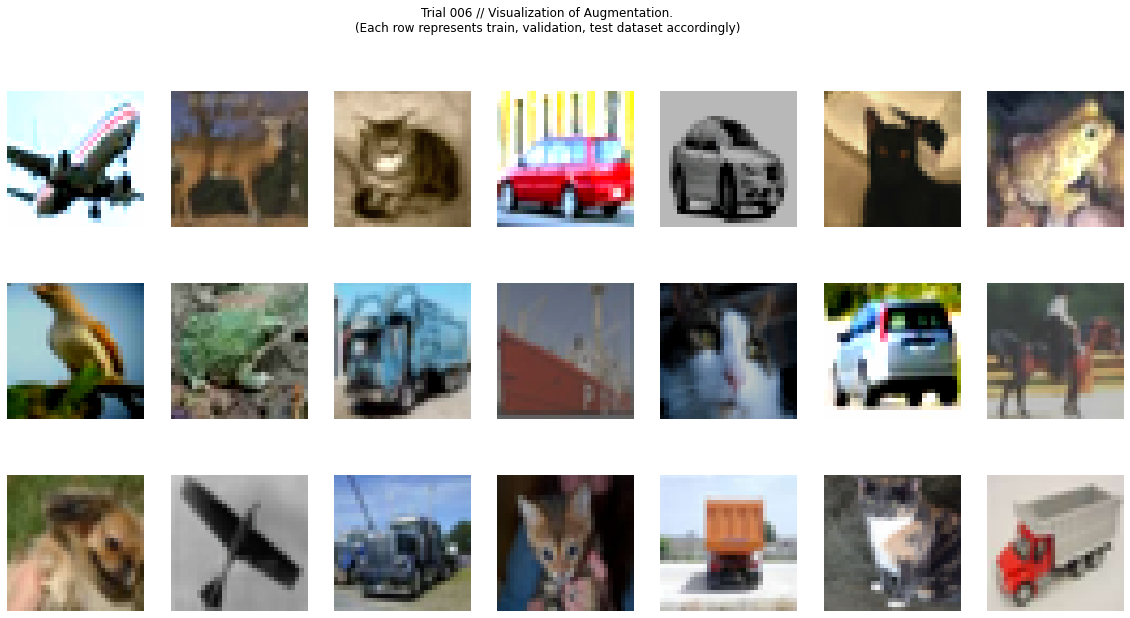

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.075, Acc: 22.06% F1(macro): 0.22: 100%|██████████| 156/156 [00:10<00:00, 14.90it/s]
 Val:       Loss: 1.843, Acc: 31.22% F1(macro): 0.30: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


Model saved. Current best test f1: 0.298


Train: [002] Loss: 1.689, Acc: 37.53% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 15.46it/s]
 Val:       Loss: 1.592, Acc: 41.01% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 19.76it/s]


Model saved. Current best test f1: 0.397


Train: [003] Loss: 1.540, Acc: 43.45% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 15.29it/s]
 Val:       Loss: 1.472, Acc: 45.95% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 19.22it/s]


Model saved. Current best test f1: 0.451


Train: [004] Loss: 1.437, Acc: 47.47% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 15.25it/s]
 Val:       Loss: 1.413, Acc: 48.62% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Model saved. Current best test f1: 0.485


Train: [005] Loss: 1.364, Acc: 50.59% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 15.14it/s]
 Val:       Loss: 1.368, Acc: 49.92% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Model saved. Current best test f1: 0.490


Train: [006] Loss: 1.304, Acc: 53.18% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 15.33it/s]
 Val:       Loss: 1.280, Acc: 53.53% F1(macro): 0.53: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s]


Model saved. Current best test f1: 0.528


Train: [007] Loss: 1.237, Acc: 55.42% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.81it/s]
 Val:       Loss: 1.281, Acc: 53.47% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Model saved. Current best test f1: 0.536


Train: [008] Loss: 1.177, Acc: 58.09% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 15.23it/s]
 Val:       Loss: 1.208, Acc: 56.40% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 17.67it/s]


Model saved. Current best test f1: 0.557


Train: [009] Loss: 1.129, Acc: 59.52% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 15.00it/s]
 Val:       Loss: 1.201, Acc: 56.96% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


Model saved. Current best test f1: 0.560


Train: [010] Loss: 1.092, Acc: 60.79% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 15.37it/s]
 Val:       Loss: 1.139, Acc: 59.04% F1(macro): 0.59: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s]


Model saved. Current best test f1: 0.587
TEST DATASET


 Val:       Loss: 1.095, Acc: 60.90% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 37.74it/s]
[I 2021-11-23 09:44:38,224] Trial 6 finished with value: 0.6056040492087778 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


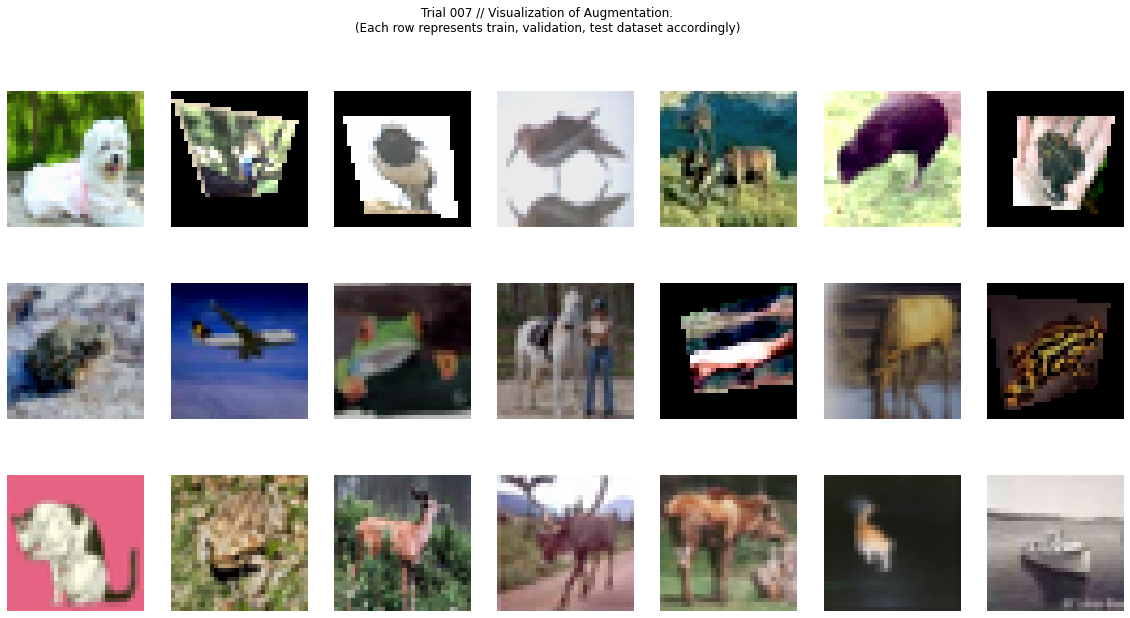

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.195, Acc: 18.25% F1(macro): 0.18: 100%|██████████| 156/156 [00:10<00:00, 15.20it/s]
 Val:       Loss: 1.999, Acc: 25.54% F1(macro): 0.23: 100%|██████████| 40/40 [00:02<00:00, 16.60it/s]


Model saved. Current best test f1: 0.234


Train: [002] Loss: 1.895, Acc: 29.95% F1(macro): 0.29: 100%|██████████| 156/156 [00:10<00:00, 14.91it/s]
 Val:       Loss: 1.796, Acc: 33.54% F1(macro): 0.31: 100%|██████████| 40/40 [00:02<00:00, 18.27it/s]


Model saved. Current best test f1: 0.312


Train: [003] Loss: 1.742, Acc: 35.61% F1(macro): 0.35: 100%|██████████| 156/156 [00:10<00:00, 14.36it/s]
 Val:       Loss: 1.708, Acc: 36.40% F1(macro): 0.35: 100%|██████████| 40/40 [00:02<00:00, 18.38it/s]


Model saved. Current best test f1: 0.352


Train: [004] Loss: 1.665, Acc: 39.07% F1(macro): 0.38: 100%|██████████| 156/156 [00:10<00:00, 14.69it/s]
 Val:       Loss: 1.610, Acc: 40.58% F1(macro): 0.40: 100%|██████████| 40/40 [00:02<00:00, 17.90it/s]


Model saved. Current best test f1: 0.399


Train: [005] Loss: 1.601, Acc: 41.58% F1(macro): 0.41: 100%|██████████| 156/156 [00:10<00:00, 14.46it/s]
 Val:       Loss: 1.558, Acc: 42.54% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s]


Model saved. Current best test f1: 0.417


Train: [006] Loss: 1.538, Acc: 44.07% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.90it/s]
 Val:       Loss: 1.552, Acc: 43.16% F1(macro): 0.43: 100%|██████████| 40/40 [00:02<00:00, 16.91it/s]


Model saved. Current best test f1: 0.426


Train: [007] Loss: 1.492, Acc: 45.91% F1(macro): 0.45: 100%|██████████| 156/156 [00:11<00:00, 14.03it/s]
 Val:       Loss: 1.495, Acc: 45.49% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s]


Model saved. Current best test f1: 0.445


Train: [008] Loss: 1.462, Acc: 46.90% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.45it/s]
 Val:       Loss: 1.423, Acc: 47.90% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 18.37it/s]


Model saved. Current best test f1: 0.472


Train: [009] Loss: 1.432, Acc: 48.03% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.44it/s]
 Val:       Loss: 1.510, Acc: 45.08% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 15.61it/s]
Train: [010] Loss: 1.405, Acc: 49.42% F1(macro): 0.49: 100%|██████████| 156/156 [00:11<00:00, 14.17it/s]
 Val:       Loss: 1.407, Acc: 48.71% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 18.05it/s]


Model saved. Current best test f1: 0.487
TEST DATASET


 Val:       Loss: 1.266, Acc: 54.44% F1(macro): 0.54: 100%|██████████| 40/40 [00:00<00:00, 41.45it/s]
[I 2021-11-23 09:47:01,590] Trial 7 finished with value: 0.5384787132840501 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


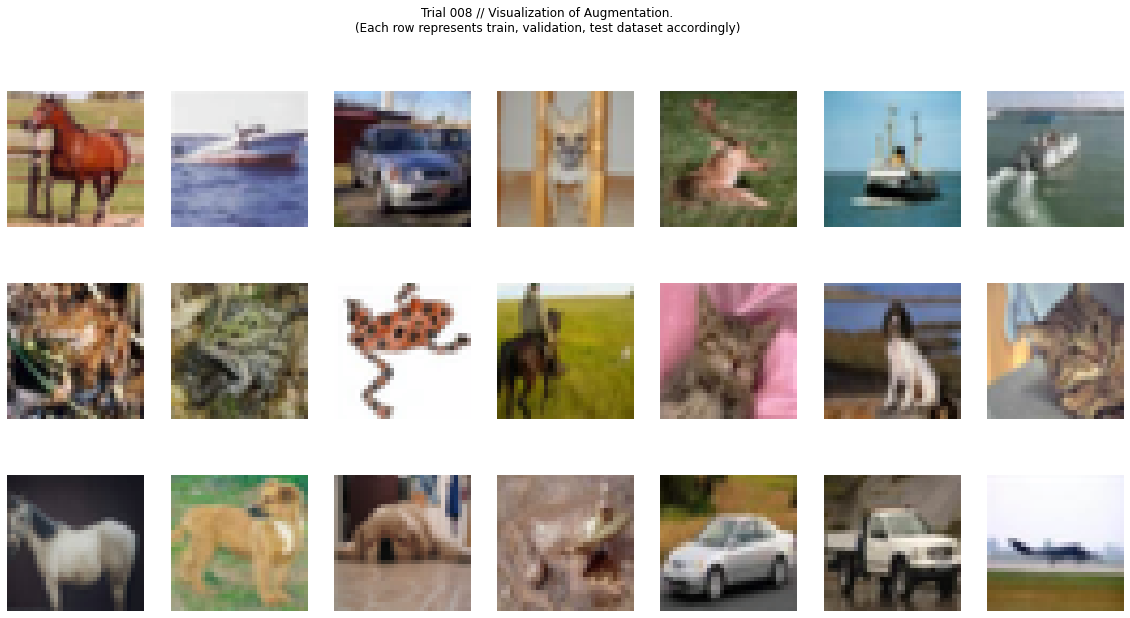

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.944, Acc: 27.95% F1(macro): 0.28: 100%|██████████| 156/156 [00:09<00:00, 15.68it/s]
 Val:       Loss: 1.668, Acc: 39.00% F1(macro): 0.37: 100%|██████████| 40/40 [00:01<00:00, 38.54it/s]


Model saved. Current best test f1: 0.369


Train: [002] Loss: 1.515, Acc: 45.18% F1(macro): 0.45: 100%|██████████| 156/156 [00:09<00:00, 15.76it/s]
 Val:       Loss: 1.469, Acc: 47.79% F1(macro): 0.48: 100%|██████████| 40/40 [00:00<00:00, 41.44it/s]


Model saved. Current best test f1: 0.475


Train: [003] Loss: 1.338, Acc: 51.40% F1(macro): 0.51: 100%|██████████| 156/156 [00:09<00:00, 15.75it/s]
 Val:       Loss: 1.375, Acc: 50.82% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 39.11it/s]


Model saved. Current best test f1: 0.500


Train: [004] Loss: 1.219, Acc: 55.98% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.70it/s]
 Val:       Loss: 1.312, Acc: 53.70% F1(macro): 0.53: 100%|██████████| 40/40 [00:00<00:00, 40.31it/s]


Model saved. Current best test f1: 0.532


Train: [005] Loss: 1.131, Acc: 59.62% F1(macro): 0.59: 100%|██████████| 156/156 [00:09<00:00, 15.95it/s]
 Val:       Loss: 1.331, Acc: 54.27% F1(macro): 0.53: 100%|██████████| 40/40 [00:00<00:00, 41.06it/s]


Model saved. Current best test f1: 0.534


Train: [006] Loss: 1.059, Acc: 62.32% F1(macro): 0.62: 100%|██████████| 156/156 [00:09<00:00, 15.89it/s]
 Val:       Loss: 1.266, Acc: 55.67% F1(macro): 0.56: 100%|██████████| 40/40 [00:00<00:00, 40.82it/s]


Model saved. Current best test f1: 0.557


Train: [007] Loss: 0.985, Acc: 64.77% F1(macro): 0.65: 100%|██████████| 156/156 [00:10<00:00, 15.06it/s]
 Val:       Loss: 1.283, Acc: 56.55% F1(macro): 0.56: 100%|██████████| 40/40 [00:00<00:00, 40.89it/s]


Model saved. Current best test f1: 0.562


Train: [008] Loss: 0.936, Acc: 66.54% F1(macro): 0.66: 100%|██████████| 156/156 [00:09<00:00, 15.82it/s]
 Val:       Loss: 1.256, Acc: 57.19% F1(macro): 0.57: 100%|██████████| 40/40 [00:00<00:00, 42.54it/s]


Model saved. Current best test f1: 0.570


Train: [009] Loss: 0.881, Acc: 68.49% F1(macro): 0.68: 100%|██████████| 156/156 [00:09<00:00, 15.60it/s]
 Val:       Loss: 1.250, Acc: 57.99% F1(macro): 0.58: 100%|██████████| 40/40 [00:00<00:00, 40.12it/s]


Model saved. Current best test f1: 0.576


Train: [010] Loss: 0.829, Acc: 70.46% F1(macro): 0.70: 100%|██████████| 156/156 [00:09<00:00, 15.65it/s]
 Val:       Loss: 1.241, Acc: 58.95% F1(macro): 0.59: 100%|██████████| 40/40 [00:00<00:00, 42.16it/s]


Model saved. Current best test f1: 0.587
TEST DATASET


 Val:       Loss: 1.219, Acc: 58.62% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 39.91it/s]
[I 2021-11-23 09:49:04,948] Trial 8 finished with value: 0.5838056539831811 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


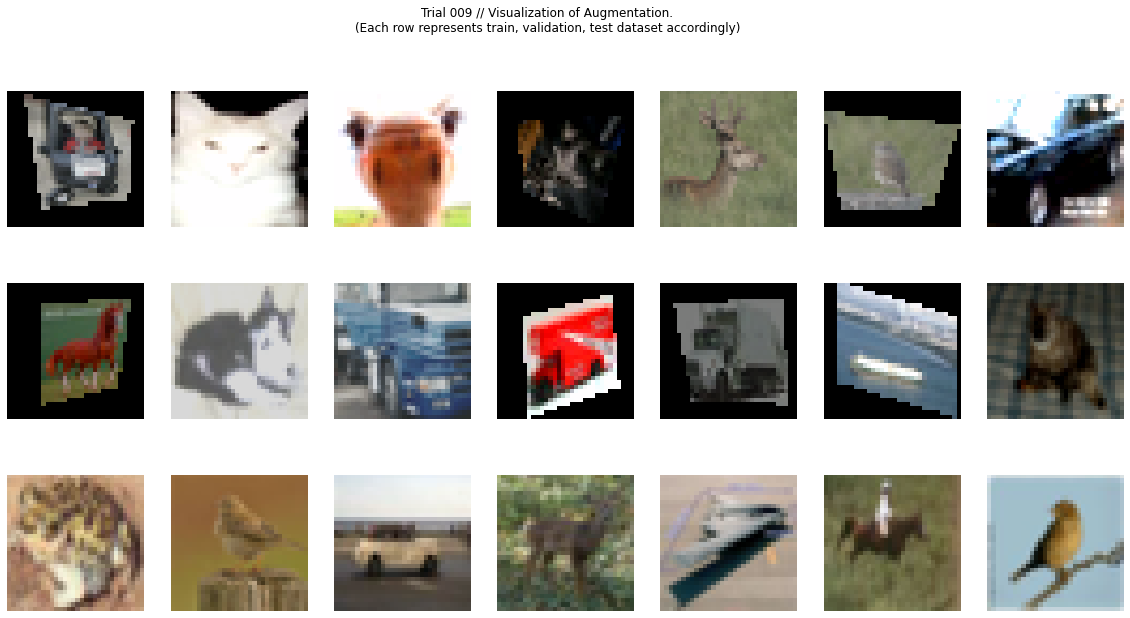

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40    

Train: [001] Loss: 2.135, Acc: 20.13% F1(macro): 0.19: 100%|██████████| 156/156 [00:11<00:00, 14.10it/s]
 Val:       Loss: 1.914, Acc: 29.95% F1(macro): 0.28: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s]


Model saved. Current best test f1: 0.277


Train: [002] Loss: 1.852, Acc: 31.58% F1(macro): 0.31: 100%|██████████| 156/156 [00:11<00:00, 14.00it/s]
 Val:       Loss: 1.743, Acc: 35.57% F1(macro): 0.35: 100%|██████████| 40/40 [00:02<00:00, 16.29it/s]


Model saved. Current best test f1: 0.352


Train: [003] Loss: 1.706, Acc: 37.14% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.67it/s]
 Val:       Loss: 1.632, Acc: 39.92% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


Model saved. Current best test f1: 0.390


Train: [004] Loss: 1.612, Acc: 40.88% F1(macro): 0.40: 100%|██████████| 156/156 [00:10<00:00, 14.29it/s]
 Val:       Loss: 1.559, Acc: 42.49% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s]


Model saved. Current best test f1: 0.412


Train: [005] Loss: 1.566, Acc: 43.11% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.46it/s]
 Val:       Loss: 1.518, Acc: 43.98% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


Model saved. Current best test f1: 0.436


Train: [006] Loss: 1.513, Acc: 44.72% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.60it/s]
 Val:       Loss: 1.463, Acc: 46.62% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 16.91it/s]


Model saved. Current best test f1: 0.460


Train: [007] Loss: 1.472, Acc: 46.35% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.64it/s]
 Val:       Loss: 1.469, Acc: 46.54% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 17.03it/s]
Train: [008] Loss: 1.424, Acc: 48.33% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 15.04it/s]
 Val:       Loss: 1.421, Acc: 47.80% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 17.15it/s]


Model saved. Current best test f1: 0.471


Train: [009] Loss: 1.391, Acc: 49.45% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 14.77it/s]
 Val:       Loss: 1.370, Acc: 50.50% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


Model saved. Current best test f1: 0.501


Train: [010] Loss: 1.364, Acc: 50.90% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.77it/s]
 Val:       Loss: 1.386, Acc: 49.66% F1(macro): 0.49: 100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

TEST DATASET



 Val:       Loss: 1.252, Acc: 56.01% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 39.36it/s]
[I 2021-11-23 09:51:28,304] Trial 9 finished with value: 0.5555007750997394 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


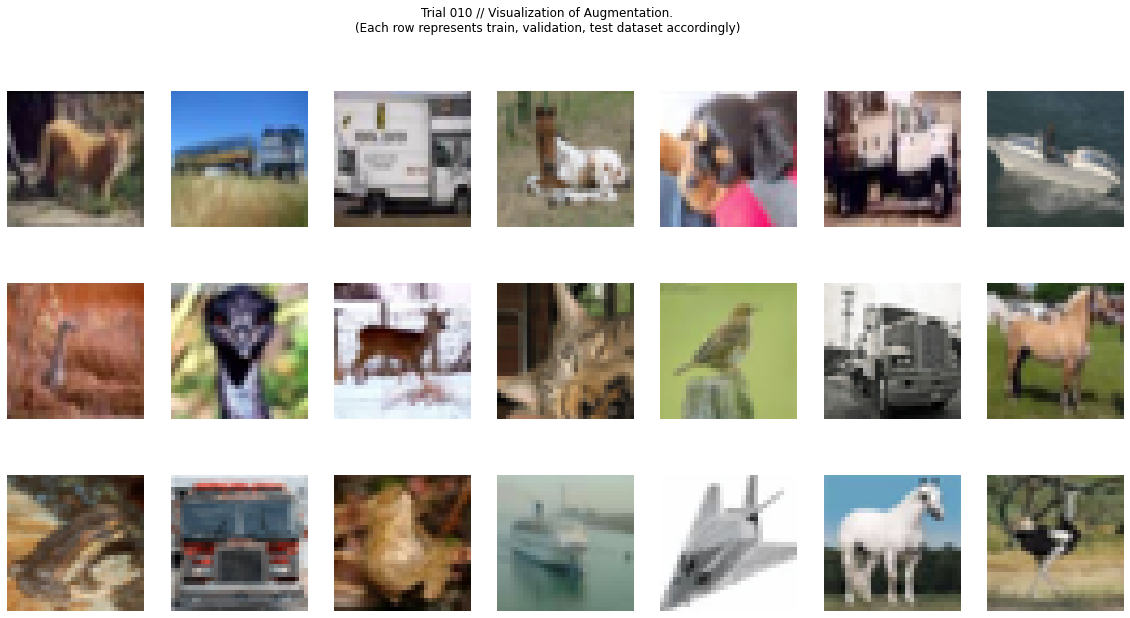

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.896, Acc: 28.99% F1(macro): 0.29: 100%|██████████| 156/156 [00:10<00:00, 15.48it/s]
 Val:       Loss: 1.589, Acc: 41.20% F1(macro): 0.40: 100%|██████████| 40/40 [00:00<00:00, 40.40it/s]


Model saved. Current best test f1: 0.405


Train: [002] Loss: 1.481, Acc: 45.41% F1(macro): 0.45: 100%|██████████| 156/156 [00:09<00:00, 15.62it/s]
 Val:       Loss: 1.383, Acc: 49.50% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 37.81it/s]


Model saved. Current best test f1: 0.488


Train: [003] Loss: 1.330, Acc: 51.75% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 15.23it/s]
 Val:       Loss: 1.285, Acc: 53.70% F1(macro): 0.54: 100%|██████████| 40/40 [00:00<00:00, 40.39it/s]


Model saved. Current best test f1: 0.536


Train: [004] Loss: 1.226, Acc: 55.82% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 15.04it/s]
 Val:       Loss: 1.214, Acc: 55.93% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 38.96it/s]


Model saved. Current best test f1: 0.556


Train: [005] Loss: 1.138, Acc: 59.15% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 15.43it/s]
 Val:       Loss: 1.172, Acc: 58.08% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 36.27it/s]


Model saved. Current best test f1: 0.576


Train: [006] Loss: 1.069, Acc: 62.00% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 15.46it/s]
 Val:       Loss: 1.155, Acc: 60.10% F1(macro): 0.60: 100%|██████████| 40/40 [00:00<00:00, 40.99it/s]


Model saved. Current best test f1: 0.601


Train: [007] Loss: 1.016, Acc: 63.84% F1(macro): 0.64: 100%|██████████| 156/156 [00:10<00:00, 15.45it/s]
 Val:       Loss: 1.106, Acc: 61.22% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 39.12it/s]


Model saved. Current best test f1: 0.612


Train: [008] Loss: 0.971, Acc: 65.70% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 15.50it/s]
 Val:       Loss: 1.060, Acc: 62.29% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 39.86it/s]


Model saved. Current best test f1: 0.624


Train: [009] Loss: 0.921, Acc: 67.47% F1(macro): 0.67: 100%|██████████| 156/156 [00:10<00:00, 15.39it/s]
 Val:       Loss: 1.033, Acc: 63.66% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 39.68it/s]


Model saved. Current best test f1: 0.635


Train: [010] Loss: 0.879, Acc: 68.90% F1(macro): 0.69: 100%|██████████| 156/156 [00:10<00:00, 15.46it/s]
 Val:       Loss: 1.015, Acc: 64.68% F1(macro): 0.65: 100%|██████████| 40/40 [00:01<00:00, 38.42it/s]


Model saved. Current best test f1: 0.647
TEST DATASET


 Val:       Loss: 1.006, Acc: 64.42% F1(macro): 0.64: 100%|██████████| 40/40 [00:01<00:00, 40.00it/s]
[I 2021-11-23 09:53:33,177] Trial 10 finished with value: 0.6428984732108823 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


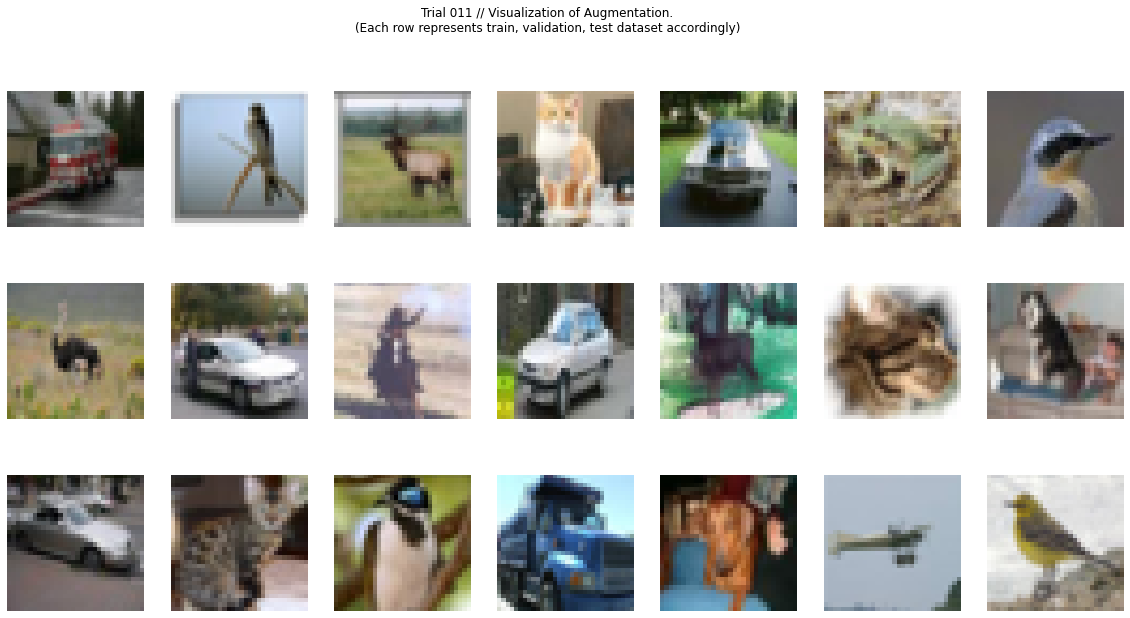

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.914, Acc: 29.66% F1(macro): 0.29: 100%|██████████| 156/156 [00:09<00:00, 15.72it/s]
 Val:       Loss: 1.611, Acc: 41.35% F1(macro): 0.40: 100%|██████████| 40/40 [00:01<00:00, 39.44it/s]


Model saved. Current best test f1: 0.401


Train: [002] Loss: 1.501, Acc: 44.90% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 15.05it/s]
 Val:       Loss: 1.465, Acc: 46.28% F1(macro): 0.45: 100%|██████████| 40/40 [00:01<00:00, 38.95it/s]


Model saved. Current best test f1: 0.452


Train: [003] Loss: 1.354, Acc: 50.73% F1(macro): 0.50: 100%|██████████| 156/156 [00:09<00:00, 15.63it/s]
 Val:       Loss: 1.344, Acc: 50.78% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 38.92it/s]


Model saved. Current best test f1: 0.498


Train: [004] Loss: 1.249, Acc: 54.61% F1(macro): 0.54: 100%|██████████| 156/156 [00:09<00:00, 15.81it/s]
 Val:       Loss: 1.249, Acc: 54.77% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 38.88it/s]


Model saved. Current best test f1: 0.550


Train: [005] Loss: 1.166, Acc: 57.94% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 14.92it/s]
 Val:       Loss: 1.216, Acc: 56.47% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 39.77it/s]


Model saved. Current best test f1: 0.561


Train: [006] Loss: 1.095, Acc: 60.53% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.94it/s]
 Val:       Loss: 1.173, Acc: 58.25% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 37.01it/s]


Model saved. Current best test f1: 0.585


Train: [007] Loss: 1.042, Acc: 62.68% F1(macro): 0.63: 100%|██████████| 156/156 [00:09<00:00, 15.63it/s]
 Val:       Loss: 1.142, Acc: 59.57% F1(macro): 0.59: 100%|██████████| 40/40 [00:00<00:00, 40.07it/s]


Model saved. Current best test f1: 0.592


Train: [008] Loss: 0.994, Acc: 64.50% F1(macro): 0.64: 100%|██████████| 156/156 [00:09<00:00, 15.64it/s]
 Val:       Loss: 1.104, Acc: 61.00% F1(macro): 0.60: 100%|██████████| 40/40 [00:00<00:00, 40.39it/s]


Model saved. Current best test f1: 0.605


Train: [009] Loss: 0.951, Acc: 66.12% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 15.58it/s]
 Val:       Loss: 1.125, Acc: 60.23% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.81it/s]
Train: [010] Loss: 0.916, Acc: 67.05% F1(macro): 0.67: 100%|██████████| 156/156 [00:09<00:00, 15.80it/s]
 Val:       Loss: 1.077, Acc: 62.37% F1(macro): 0.62: 100%|██████████| 40/40 [00:00<00:00, 40.44it/s]


Model saved. Current best test f1: 0.622
TEST DATASET


 Val:       Loss: 1.068, Acc: 61.89% F1(macro): 0.62: 100%|██████████| 40/40 [00:00<00:00, 40.97it/s]
[I 2021-11-23 09:55:36,736] Trial 11 finished with value: 0.6164081296889221 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


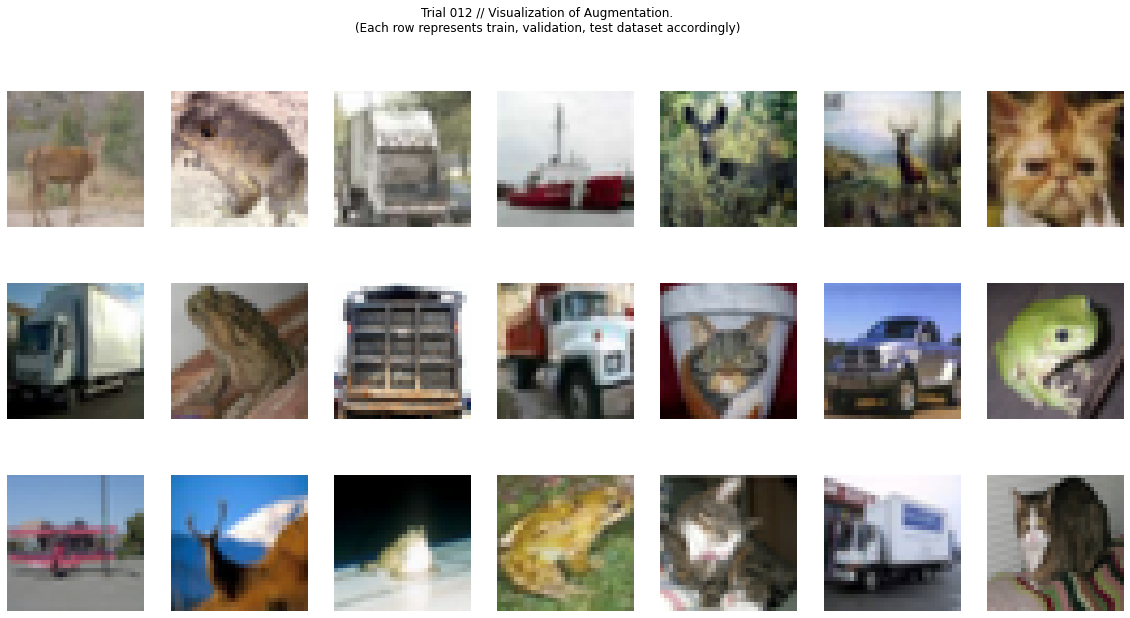

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.970, Acc: 26.94% F1(macro): 0.26: 100%|██████████| 156/156 [00:10<00:00, 15.32it/s]
 Val:       Loss: 1.710, Acc: 38.62% F1(macro): 0.37: 100%|██████████| 40/40 [00:00<00:00, 40.28it/s]


Model saved. Current best test f1: 0.374


Train: [002] Loss: 1.508, Acc: 44.70% F1(macro): 0.44: 100%|██████████| 156/156 [00:09<00:00, 15.83it/s]
 Val:       Loss: 1.421, Acc: 48.34% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 39.51it/s]


Model saved. Current best test f1: 0.480


Train: [003] Loss: 1.355, Acc: 50.68% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 15.26it/s]
 Val:       Loss: 1.350, Acc: 51.19% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 39.23it/s]


Model saved. Current best test f1: 0.507


Train: [004] Loss: 1.246, Acc: 54.89% F1(macro): 0.55: 100%|██████████| 156/156 [00:09<00:00, 15.70it/s]
 Val:       Loss: 1.269, Acc: 54.84% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 39.54it/s]


Model saved. Current best test f1: 0.542


Train: [005] Loss: 1.172, Acc: 58.04% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 15.49it/s]
 Val:       Loss: 1.204, Acc: 56.82% F1(macro): 0.57: 100%|██████████| 40/40 [00:00<00:00, 41.92it/s]


Model saved. Current best test f1: 0.568


Train: [006] Loss: 1.105, Acc: 60.22% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 15.50it/s]
 Val:       Loss: 1.168, Acc: 58.85% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 38.66it/s]


Model saved. Current best test f1: 0.586


Train: [007] Loss: 1.050, Acc: 62.37% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 15.38it/s]
 Val:       Loss: 1.123, Acc: 60.41% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 38.59it/s]


Model saved. Current best test f1: 0.606


Train: [008] Loss: 0.998, Acc: 64.42% F1(macro): 0.64: 100%|██████████| 156/156 [00:09<00:00, 15.94it/s]
 Val:       Loss: 1.115, Acc: 61.01% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 38.00it/s]


Model saved. Current best test f1: 0.613


Train: [009] Loss: 0.957, Acc: 65.75% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 14.93it/s]
 Val:       Loss: 1.071, Acc: 62.31% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 38.37it/s]


Model saved. Current best test f1: 0.622


Train: [010] Loss: 0.927, Acc: 67.09% F1(macro): 0.67: 100%|██████████| 156/156 [00:10<00:00, 15.24it/s]
 Val:       Loss: 1.058, Acc: 62.76% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 33.42it/s]


Model saved. Current best test f1: 0.633
TEST DATASET


 Val:       Loss: 1.081, Acc: 61.65% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 39.82it/s]
[I 2021-11-23 09:57:41,685] Trial 12 finished with value: 0.6193291835964756 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6480624514967079.


Files already downloaded and verified
Files already downloaded and verified


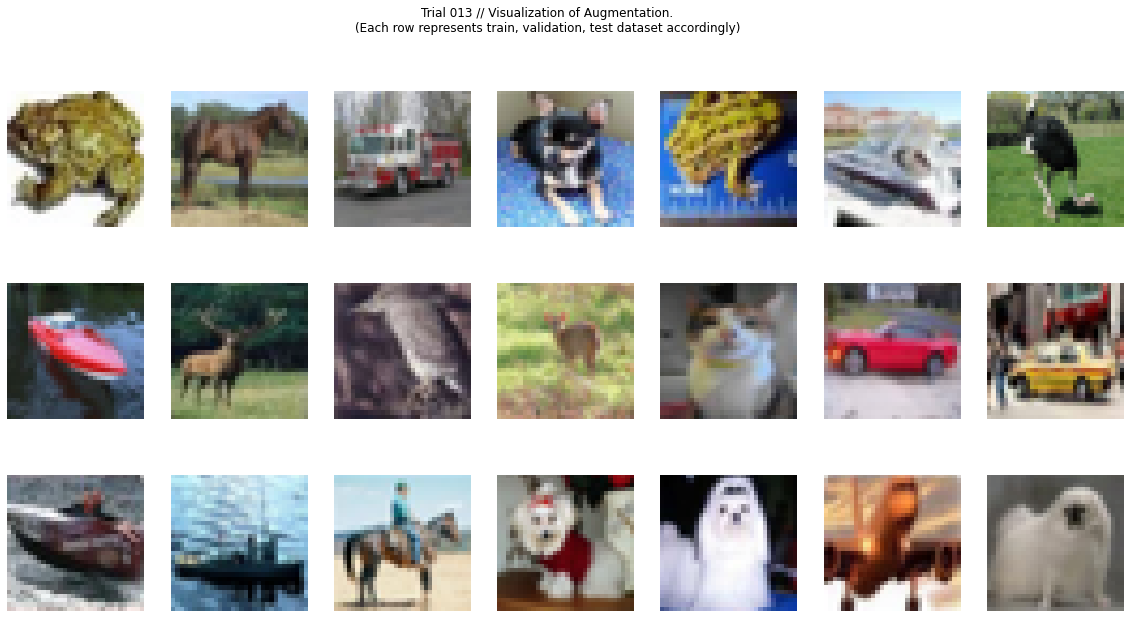

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.945, Acc: 27.16% F1(macro): 0.27: 100%|██████████| 156/156 [00:10<00:00, 15.45it/s]
 Val:       Loss: 1.689, Acc: 38.90% F1(macro): 0.37: 100%|██████████| 40/40 [00:01<00:00, 39.33it/s]


Model saved. Current best test f1: 0.370


Train: [002] Loss: 1.500, Acc: 44.95% F1(macro): 0.45: 100%|██████████| 156/156 [00:10<00:00, 15.01it/s]
 Val:       Loss: 1.405, Acc: 48.77% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 39.35it/s]


Model saved. Current best test f1: 0.480


Train: [003] Loss: 1.347, Acc: 50.94% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 15.19it/s]
 Val:       Loss: 1.322, Acc: 52.59% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 38.55it/s]


Model saved. Current best test f1: 0.515


Train: [004] Loss: 1.240, Acc: 55.06% F1(macro): 0.55: : 161it [00:08, 13.57it/s]

In [9]:
study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(objective, n_trials=100)